# Homework #3 - Rossman Store Sales

Group Members:

Hoo De Lin (A0126576X)

Yap Han Chiang (A0125168E)

# Analyzing the data:

Before we try figuring out which model to fit in, we need to understand the data, and clean/modify the data to be able to feed into any model

The feature that I believe are quite important are:

- Competition
- Holidays
- Type of stores
- Type of day (Monday - Sunday)
- Having promotions
- Promo2 since

Interesting to note is that, 

First, we load the dependencies that we would need

In [104]:
import numpy as np
import pandas as pd
import math
from datetime import datetime
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as pl
%matplotlib inline
import seaborn as sb 
import csv

# import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, mean_squared_error

Then, we would load the training data and store data and join them together for processing later

In [105]:
trainData = pd.read_csv('train_v2.csv', parse_dates=['Date'], dtype={'StateHoliday': 'str'})
testData = pd.read_csv('test_v2.csv',  parse_dates=['Date'], dtype={'StateHoliday': 'str'})
storeData = pd.read_csv('store.csv')

trainData = pd.merge(storeData, trainData, on='Store')
testData = pd.merge(storeData, testData, on='Store')
# testDataUnsanitized = pd.read_csv('test_v2.csv',  parse_dates=['Date'], dtype={'StateHoliday': 'str'})

Before we proceed any feature engineering or model training, we would like to see the general trend of the sales. Below are all store sale trends based on the store type and the assortment

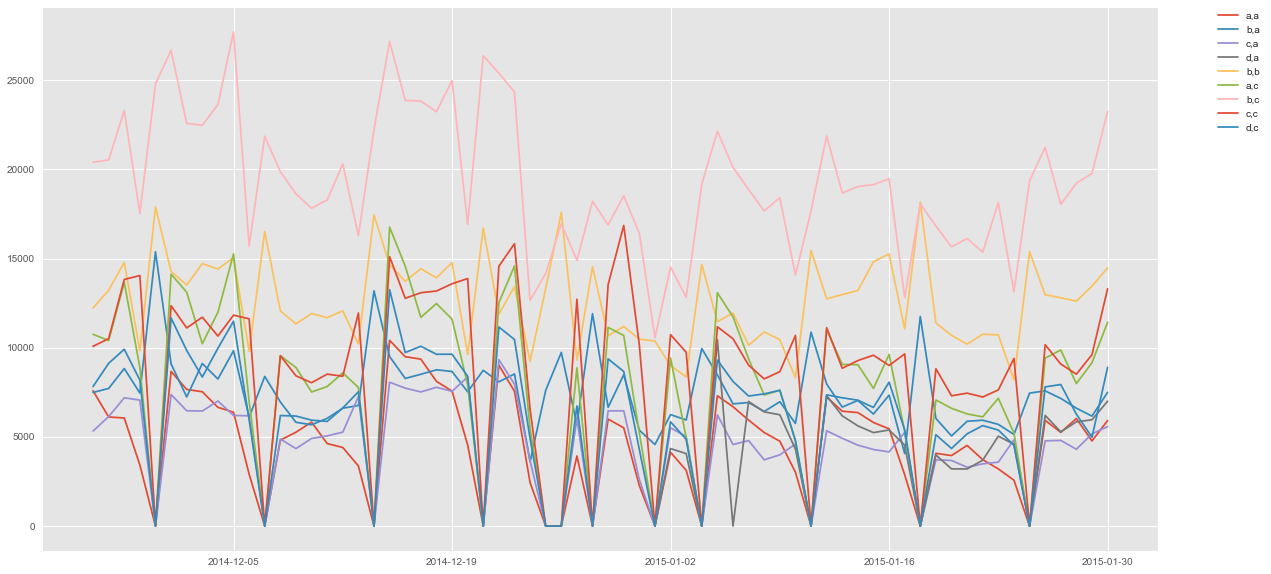

In [106]:
def plotSalesData(store_type, assortment):
    store = trainData[(trainData.StoreType == store_type) & (trainData.Assortment == assortment)].Store.iloc[0]
    store_sales = trainData[trainData.Store == store].sort_values('Date')
    pl.plot(store_sales.Date, store_sales.Sales, label=store_type+","+assortment)
pl.figure(figsize=(20,10))
plotSalesData('a','a')
plotSalesData('b','a')
plotSalesData('c','a')
plotSalesData('d','a')
# plotSalesData('a','b')
plotSalesData('b','b')
# plotSalesData('c','b')
# plotSalesData('d','b')
plotSalesData('a','c')
plotSalesData('b','c')
plotSalesData('c','c')
plotSalesData('d','c')
pl.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
pl.show()
# storeSalesGraph1 = trainData[trainData.Store==123].sort_values('Date')
# pl.figure(figsize=(20, 10))
# pl.plot(storeSalesGraph1.Date, storeSalesGraph1.Sales)

We can see that all the stores follow a general trend. TODO: talk about the trend
- Monday always have a higher sales than other day in the week

In [107]:
# Cleaning the data
def hasHoliday(row):
    if row['StateHoliday'] != "0" or row['SchoolHoliday'] != "0":
        return 1
    else:
        return 0
def calculateCompetitionAge(row):
        if math.isnan(row['CompetitionOpenSinceMonth']):
            return 0
        else:
            f_date = datetime(int(row['CompetitionOpenSinceYear']), int(row['CompetitionOpenSinceMonth']), 1, 0, 0, 0)
            return (row['Date'].to_pydatetime() - f_date).days

month_num_name_dict = {
    "1": "Jan",
    "2": "Feb",
    "3": "Mar",
    "4": "Apr",
    "5": "May",
    "6": "Jun",
    "7": "Jul",
    "8": "Aug",
    "9": "Sept",
    "10": "Oct",
    "11": "Nov",
    "12": "Dec"
}

def isHavingPromo2(row):
    if not isinstance(row['PromoInterval'], str):
        return 0
    elif month_num_name_dict[str(row['Date'].to_pydatetime().month)] in row['PromoInterval']:
        return 1
    else:
        return 0

# Possible thought: If we are not at the promo interval, should promo2Age have any effect?
def promo2Age(row):
    if row['Promo2'] == 0:
        return 0
    else:
#        https://stackoverflow.com/a/17087427
        date = str(int(row["Promo2SinceYear"])) + "-W" + str(int(row["Promo2SinceWeek"]))
        f_date = datetime.strptime(date + '-0', "%Y-W%W-%w")
        return (row['Date'].to_pydatetime() - f_date).days

In [108]:
trainData['HasHoliday'] = trainData.apply(lambda row: hasHoliday(row), axis=1)
trainData['CompetitionAge'] = trainData.apply(lambda row: calculateCompetitionAge(row), axis=1)
trainData['HavingPromo2'] = trainData.apply(lambda row: isHavingPromo2(row), axis=1)
trainData['Promo2Age'] = trainData.apply(lambda row: promo2Age(row), axis=1)
trainData = pd.get_dummies(trainData, columns=['DayOfWeek', 'StoreType', 'Assortment'])
trainData.fillna(0, inplace=True)

In [109]:
trainData.drop('CompetitionOpenSinceMonth', axis=1, inplace=True)
trainData.drop('CompetitionOpenSinceYear', axis=1, inplace=True)
trainData.drop('StateHoliday', axis=1, inplace=True)
trainData.drop('SchoolHoliday', axis=1, inplace=True)
trainData.drop('Promo2SinceWeek', axis=1, inplace=True)
trainData.drop('Promo2SinceYear', axis=1, inplace=True)
trainData.drop('PromoInterval', axis=1, inplace=True)
trainData.drop('Promo2', axis=1, inplace=True)
trainData.drop('Open', axis=1, inplace=True)
trainDataSanitizedStore = trainData.loc[:, 'Store']

In [110]:
trainData

,Store,CompetitionDistance,Date,Sales,Customers,Promo,HasHoliday,CompetitionAge,HavingPromo2,Promo2Age,...,DayOfWeek_5,DayOfWeek_6,DayOfWeek_7,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c
0,1,1270.0,2015-01-30,5577,616,1,1,2342,0,0,...,1,0,0,0,0,1,0,1,0,0
1,1,1270.0,2015-01-29,5171,573,1,1,2341,0,0,...,0,0,0,0,0,1,0,1,0,0
2,1,1270.0,2015-01-28,4310,537,1,1,2340,0,0,...,0,0,0,0,0,1,0,1,0,0
3,1,1270.0,2015-01-27,4806,532,1,1,2339,0,0,...,0,0,0,0,0,1,0,1,0,0
4,1,1270.0,2015-01-26,4781,566,1,1,2338,0,0,...,0,0,0,0,0,1,0,1,0,0
5,1,1270.0,2015-01-25,0,0,0,1,2337,0,0,...,0,0,1,0,0,1,0,1,0,0
6,1,1270.0,2015-01-24,4840,600,0,1,2336,0,0,...,0,1,0,0,0,1,0,1,0,0
7,1,1270.0,2015-01-23,3586,489,0,1,2335,0,0,...,1,0,0,0,0,1,0,1,0,0
8,1,1270.0,2015-01-22,3492,493,0,1,2334,0,0,...,0,0,0,0,0,1,0,1,0,0
9,1,1270.0,2015-01-21,3299,460,0,1,2333,0,0,...,0,0,0,0,0,1,0,1,0,0


After some cleaning on the training data, we'll try and use a simple linear regression to see if our model can predict the sales data

In [128]:
X = trainData.drop(['Sales', 'Date', 'Store'], axis=1).values
y = trainData.Sales.values
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)
lr = LinearRegression()
clf = lr.fit(X_train, y_train)
print(clf.score(X_val, y_val))
lr.fit(X,y)

0.904158563581


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Let's plot this with one of the store and look at the prediction

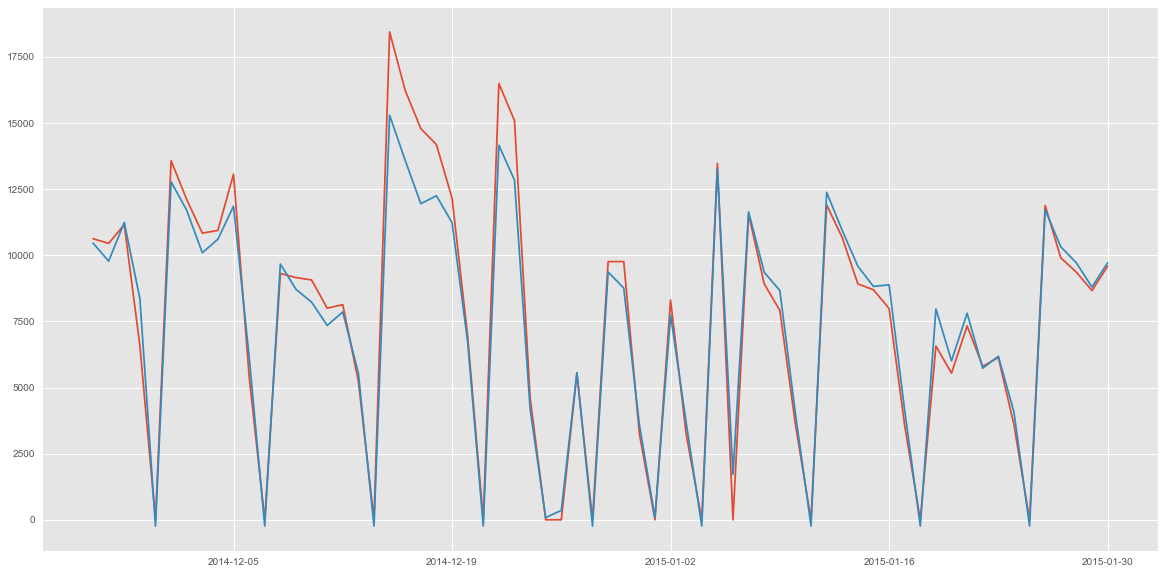

In [129]:
store = trainData[trainData.Store == 123].sort_values('Date')
pl.figure(figsize=(20,10))
pl.plot(store.Date, store.Sales, label="Actual")
X_store = store.drop(['Sales', 'Date', 'Store'], axis=1).values
prediction = lr.predict(X_store)
pl.plot(store.Date, prediction, label="prediction")
pl.show()

Let's process the test data as well

In [137]:
testData = pd.read_csv('test_v2.csv',  parse_dates=['Date'], dtype={'StateHoliday': 'str'})
testData = pd.merge(storeData, testData, on='Store')
testData['HasHoliday'] = testData.apply(lambda row: hasHoliday(row), axis=1)
testData['CompetitionAge'] = testData.apply(lambda row: calculateCompetitionAge(row), axis=1)
testData['HavingPromo2'] = testData.apply(lambda row: isHavingPromo2(row), axis=1)
testData['Promo2Age'] = testData.apply(lambda row: promo2Age(row), axis=1)
testData = pd.get_dummies(testData, columns=['DayOfWeek', 'StoreType', 'Assortment'])
testData.fillna(0, inplace=True)

In [138]:
testData.drop('CompetitionOpenSinceMonth', axis=1, inplace=True)
testData.drop('CompetitionOpenSinceYear', axis=1, inplace=True)
testData.drop('StateHoliday', axis=1, inplace=True)
testData.drop('SchoolHoliday', axis=1, inplace=True)
testData.drop('Promo2SinceWeek', axis=1, inplace=True)
testData.drop('Promo2SinceYear', axis=1, inplace=True)
testData.drop('PromoInterval', axis=1, inplace=True)
testData.drop('Promo2', axis=1, inplace=True)
testData.drop('Open', axis=1, inplace=True)
testDataSanitizedStore = testData.loc[:, 'Store']
testData.drop('Store', axis=1, inplace=True)
testData.drop('Date', axis=1, inplace=True)

In [139]:
testData

,CompetitionDistance,Customers,Promo,HasHoliday,CompetitionAge,HavingPromo2,Promo2Age,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,...,DayOfWeek_5,DayOfWeek_6,DayOfWeek_7,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c
0,1270.0,555,1,1,2524,0,0,0,0,0,...,1,0,0,0,0,1,0,1,0,0
1,1270.0,546,1,1,2523,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
2,1270.0,523,1,1,2522,0,0,0,0,1,...,0,0,0,0,0,1,0,1,0,0
3,1270.0,560,1,1,2521,0,0,0,1,0,...,0,0,0,0,0,1,0,1,0,0
4,1270.0,612,1,1,2520,0,0,1,0,0,...,0,0,0,0,0,1,0,1,0,0
5,1270.0,0,0,1,2519,0,0,0,0,0,...,0,0,1,0,0,1,0,1,0,0
6,1270.0,500,0,1,2518,0,0,0,0,0,...,0,1,0,0,0,1,0,1,0,0
7,1270.0,459,0,1,2517,0,0,0,0,0,...,1,0,0,0,0,1,0,1,0,0
8,1270.0,503,0,1,2516,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
9,1270.0,463,0,1,2515,0,0,0,0,1,...,0,0,0,0,0,1,0,1,0,0


In [142]:
results = lr.predict(testData)
print(len(results))
with open('submission.csv', 'w') as csvfile:
    fieldnames = ['Id', 'Sales']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    for idx, val in enumerate(results):
        writer.writerow({'Id': idx + 1, 'Sales': val})
    csvfile.close()

33450


Let's try XGBoost:

In [148]:
X = trainData.drop(['Sales', 'Date', 'Store'], axis=1).values
y = trainData.Sales.values
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)
xgb = XGBRegressor()
clf = xgb.fit(X_train, y_train)
print(clf.score(X_val, y_val))
xgb.fit(X,y)
print(testData)

0.941403476048
       CompetitionDistance  Customers  Promo  HasHoliday  CompetitionAge  \
0                   1270.0        555      1           1            2524   
1                   1270.0        546      1           1            2523   
2                   1270.0        523      1           1            2522   
3                   1270.0        560      1           1            2521   
4                   1270.0        612      1           1            2520   
5                   1270.0          0      0           1            2519   
6                   1270.0        500      0           1            2518   
7                   1270.0        459      0           1            2517   
8                   1270.0        503      0           1            2516   
9                   1270.0        463      0           1            2515   
10                  1270.0        469      0           1            2514   
11                  1270.0        526      0           1            2513 

In [ ]:
results = xgb.predict(testData.as_matrix())
with open('submission.csv', 'w') as csvfile:
    fieldnames = ['Id', 'Sales']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    for idx, val in enumerate(results):
        writer.writerow({'Id': idx + 1, 'Sales': val})
    csvfile.close()

In [ ]:
from sklearn.ensemble import RandomForestRegressor
def changeItToMonth(row):
    return row['CompetitionAge'] / 30
def changeItToMonthPromo(row):
    return row['Promo2Age'] / 30
_trainData = trainData[trainData.Customers != 0]
_trainData['CompetitionAge'] = _trainData.apply(lambda row: changeItToMonth(row), axis=1)
_trainData['Promo2Age'] = _trainData.apply(lambda row: changeItToMonthPromo(row), axis=1)
print(list(_trainData))
_trainData.drop('CompetitionDistance', axis=1, inplace=True)
X = _trainData.drop(['Sales', 'Date', 'Store'], axis=1).values
y = _trainData.Sales.values
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)
rfr = RandomForestRegressor(n_estimators=1)
clf = rfr.fit(X_train, y_train)
print(clf.score(X_val, y_val))
rfr.fit(X,y)
print(rfr.feature_importances_)
_testData = testData
# _testData.drop(['Promo2Age'],inplace=True, axis=1)
_testData['CompetitionAge'] = _testData.apply(lambda row: changeItToMonth(row), axis=1)
_testData['Promo2Age'] = _testData.apply(lambda row: changeItToMonthPromo(row), axis=1)
_testData.drop('CompetitionDistance', axis=1, inplace=True)
results = rfr.predict(testData.as_matrix())
store_closed_index = np.where(testData.Customers == 0)[0]

for val in store_closed_index:
    results[val] = 0
with open('submission.csv', 'w') as csvfile:
    fieldnames = ['Id', 'Sales']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    for idx, val in enumerate(results):
        writer.writerow({'Id': idx + 1, 'Sales': val})
    csvfile.close()
importances = rfr.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfr.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
# print("Feature ranking:")
# print(X)
# for f in range(X.shape[1]):
#     print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# # Plot the feature importances of the forest
# pl.figure()
# pl.title("Feature importances")
# pl.bar(range(X.shape[1]), importances[indices],
#        color="r", yerr=std[indices], align="center")
# pl.xticks(range(X.shape[1]), indices)
# pl.xlim([-1, X.shape[1]])
# pl.show()

In [532]:
# Technically we don't need this anymore lol

# 1. Replace all NaN values with 0
# 2. Map all character to integers

# For mapping StateHoliday, StoreType, Assortment to integers
mapCharToInt = {'0': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4}
mapPromoIntervalToInt = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6, 'Jul': 7,
                        'Aug': 8, 'Sept': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}
def clean_data():
    storeDataUnsanitized.fillna(0, inplace=True)
    trainData.fillna(0, inplace=True)
    testData.fillna(0, inplace=True)
    
    storeDataUnsanitized.replace(mapCharToInt, inplace=True)
    trainData.replace(mapCharToInt, inplace=True)
    testData.replace(mapCharToInt, inplace=True)
    return (storeDataUnsanitized, trainData, testData)

In [533]:
storeDataSanitized, trainDataSanitized, testDataSanitized = clean_data()
trainDataSanitized.head()

,StoreType,Assortment,CompetitionDistance,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,DayOfWeek,Date,Sales,Customers,Open,Promo,hasHoliday,CompetitionAge,havingPromo2
0,3,1,1270.0,0,0.0,0.0,0,5,2015-01-30,5577,616,1,1,1,2342,0
1,3,1,1270.0,0,0.0,0.0,0,4,2015-01-29,5171,573,1,1,1,2341,0
2,3,1,1270.0,0,0.0,0.0,0,3,2015-01-28,4310,537,1,1,1,2340,0
3,3,1,1270.0,0,0.0,0.0,0,2,2015-01-27,4806,532,1,1,1,2339,0
4,3,1,1270.0,0,0.0,0.0,0,1,2015-01-26,4781,566,1,1,1,2338,0


In [534]:
testDataSanitized.head()

,StoreType,Assortment,CompetitionDistance,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,DayOfWeek,Date,Customers,Open,Promo,hasHoliday,CompetitionAge,havingPromo2
0,3,1,1270.0,0,0.0,0.0,0,5,2015-07-31,555,1,1,1,2524,0
1,3,1,1270.0,0,0.0,0.0,0,4,2015-07-30,546,1,1,1,2523,0
2,3,1,1270.0,0,0.0,0.0,0,3,2015-07-29,523,1,1,1,2522,0
3,3,1,1270.0,0,0.0,0.0,0,2,2015-07-28,560,1,1,1,2521,0
4,3,1,1270.0,0,0.0,0.0,0,1,2015-07-27,612,1,1,1,2520,0


In [535]:
# Save some data, drop some columns
if 'Date' in trainDataSanitized.columns:
    trainDataSanitizedDate = trainDataSanitized.loc[:, 'Date']
    trainDataSanitized.drop('Date', axis=1, inplace=True)
if 'PromoInterval' in trainDataSanitized.columns:
    trainDataSanitizedPromoInterval = trainDataSanitized.loc[:, 'PromoInterval']
    trainDataSanitized.drop('PromoInterval', axis=1, inplace=True)
if 'Sales' in trainDataSanitized:
    trainDataSanitizedLabel = trainDataSanitized.loc[:, 'Sales']
    trainDataSanitized.drop('Sales', axis=1, inplace=True)
    
if 'Date' in testDataSanitized.columns:
    testDataSanitizedDate = testDataSanitized.loc[:, 'Date']
    testDataSanitizedDate = testDataSanitizedDate.apply(lambda a: a.strftime("%Y-%m-%d"))
    testDataSanitized.drop('Date', axis=1, inplace=True)
if 'PromoInterval' in testDataSanitized.columns:
    testDataSanitizedPromoInterval = testDataSanitized.loc[:, 'PromoInterval']
    testDataSanitized.drop('PromoInterval', axis=1, inplace=True)


In [536]:
model = XGBRegressor().fit(trainDataSanitized, trainDataSanitizedLabel)
prediction = model.predict(testDataSanitized)
print(prediction)

[ 5003.86816406  4956.06835938  4777.61376953 ...,  5411.32177734
  6632.65576172  6349.30712891]


In [587]:
def dateStringToInt(dateString):
    (year, month, day) = dateString.split('-')
    result = int(year + month + day)
    return result

In [588]:
testDataSanitizedInt = testDataSanitizedDate.apply(lambda x: dateStringToInt(x))

In [609]:
def writeResultToFile(result):
    with open('submission.csv', 'w', newline='') as csvfile:
        writer = csv.writer(csvfile, quoting=csv.QUOTE_MINIMAL)
        writer.writerow(['Id', 'Sales'])
        rows = list(zip(testDataSanitizedStore, testDataSanitizedInt))
        for i in range(prediction.shape[0]):
            row = rows[i]
            # print(type(row[0]), type(row[1]))
            # writer.writerow({'Id': row, 'Sales': prediction[i]})
            writer.writerow([row, prediction[i]])

In [621]:
# print(trainDataSanitizedDate[0].strftime("%Y-%m-%d"))
# print(testDataSanitizedStore.shape) == 33450
# print(prediction.shape) == 33450
# sales = prediction[0]
# ident = testDataSanitizedStore.iloc[i]
a = list(zip(testDataSanitizedStoreInt, testDataSanitizedInt))
print(a[0])

# writeResultToFile(prediction)

(1, 20150731)


In [627]:
with open('submission.csv', newline='') as csvfile:
    reader = csv.reader(csvfile)
    i = 0
    for row in reader:
        if i == 10:
            break
        print(row)
        i += 1

['Id', 'Sales']
['(1, 20150731)', '5003.87']
['(1, 20150730)', '4956.07']
['(1, 20150729)', '4777.61']
['(1, 20150728)', '5268.43']
['(1, 20150727)', '6148.67']
['(1, 20150726)', '-269.62']
['(1, 20150725)', '4192.24']
['(1, 20150724)', '3674.13']
['(1, 20150723)', '4071.19']
